# **Import necessary libraries**

In [1]:
import os
import copy
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torchvision
from torchvision import models
from sklearn.utils import shuffle
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.font_manager
from collections import OrderedDict

# **Load data**

### Change device

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

import os
print(os.getcwd())

/content


### Download dataset

In [3]:
if "food-101" in os.listdir():
    print("Dataset already exists")
else:
    print("Downloading the data...")
    !wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
    print("Dataset downloaded!")
    print("Extracting data..")
    !tar xzvf food-101.tar.gz > /dev/null 2>&1
    print("Extraction done!")

--2023-11-18 19:11:44--  http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz [following]
--2023-11-18 19:11:45--  https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4996278331 (4.7G) [application/x-gzip]
Saving to: ‘food-101.tar.gz’

food-101.tar.gz     100%[===================>]   4.65G  17.1MB/s    in 3m 46s  

2023-11-18 19:15:31 (21.1 MB/s) - ‘food-101.tar.gz’ saved [4996278331/4996278331]

Dataset downloaded!
Extracting data..
Extraction done!


### Store data

In [5]:
classes = open("./food-101/meta/classes.txt", 'r').read().splitlines()
classes_21 = classes[:20] + ['other...']
classes_21, len(classes_21)

(['apple_pie',
  'baby_back_ribs',
  'baklava',
  'beef_carpaccio',
  'beef_tartare',
  'beet_salad',
  'beignets',
  'bibimbap',
  'bread_pudding',
  'breakfast_burrito',
  'bruschetta',
  'caesar_salad',
  'cannoli',
  'caprese_salad',
  'carrot_cake',
  'ceviche',
  'cheesecake',
  'cheese_plate',
  'chicken_curry',
  'chicken_quesadilla',
  'other...'],
 21)

In [50]:
classes = classes + ['other']
print(classes,len(classes))

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheesecake', 'cheese_plate', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons', 'miso_sou

In [7]:
!echo "Testing images"
!head -n 5 ./food-101/meta/test.txt
!echo -e "\nTraining images"
!head -n 5 ./food-101/meta/train.txt | head -n 5

Testing images
apple_pie/1011328
apple_pie/101251
apple_pie/1034399
apple_pie/103801
apple_pie/1038694

Training images
apple_pie/1005649
apple_pie/1014775
apple_pie/1026328
apple_pie/1028787
apple_pie/1043283


In [8]:
def prep_df(path: str) -> pd.DataFrame:
    array = open(path, 'r').read().splitlines()

    # Getting the full path for the images
    img_path = "./food-101/images/"
    full_path = [img_path + img + ".jpg" for img in array]

    # Splitting the image index from the label
    imgs = []
    for img in array:
        img = img.split('/')

        imgs.append(img)

    imgs = np.array(imgs)
    # Converting the array to a data frame
    imgs = pd.DataFrame(imgs[:,0], imgs[:,1], columns=['label'])
    # Adding the full path to the data frame
    imgs['path'] = full_path

    # Randomly shuffling the order to the data in the dataframe
    imgs = shuffle(imgs)

    return imgs

In [9]:
train_imgs = prep_df('./food-101/meta/train.txt')
test_imgs = prep_df('./food-101/meta/test.txt')

train_imgs.head(5)

,label,path
1245221,miso_soup,./food-101/images/miso_soup/1245221.jpg
1726094,shrimp_and_grits,./food-101/images/shrimp_and_grits/1726094.jpg
3428917,gyoza,./food-101/images/gyoza/3428917.jpg
1182396,cheese_plate,./food-101/images/cheese_plate/1182396.jpg
3374418,spaghetti_carbonara,./food-101/images/spaghetti_carbonara/3374418.jpg


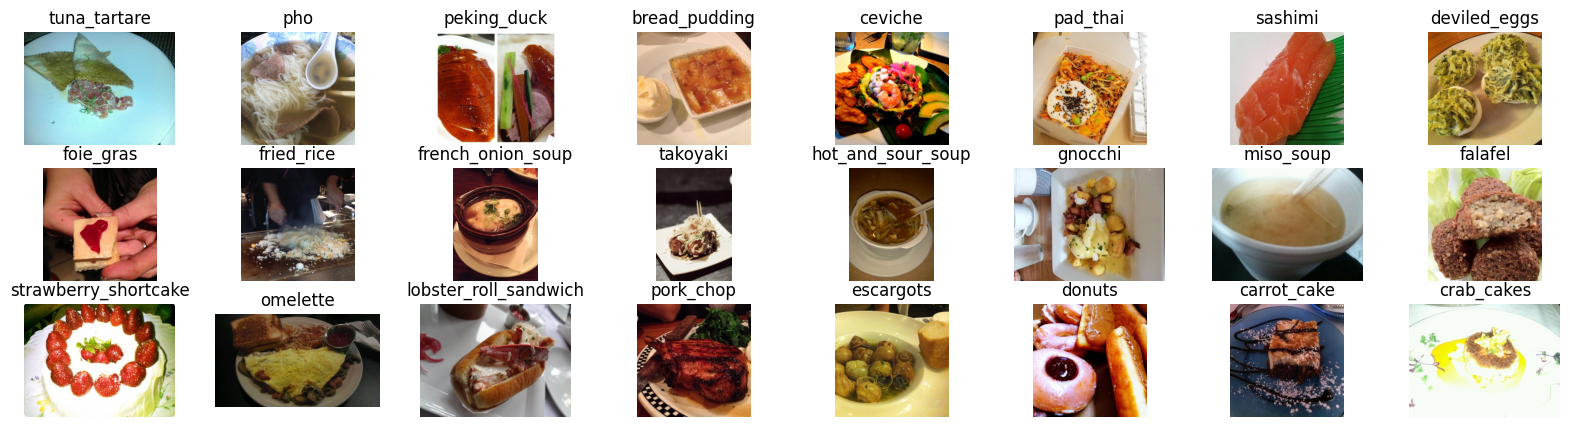

In [10]:
plt.figure(figsize=(20, 5))

num_rows = 3
num_cols = 8


for idx in range(num_rows * num_cols):
    random_idx = np.random.randint(0, train_imgs.shape[0])
    img = plt.imread(train_imgs.path.iloc[random_idx])

    label = train_imgs.label.iloc[random_idx]

    ax = plt.subplot(num_rows, num_cols, idx + 1)
    plt.imshow(img)
    plt.title(label)
    plt.axis("off")

### Data augmentation

train

In [11]:
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       torchvision.transforms.AutoAugment(torchvision.transforms.AutoAugmentPolicy.IMAGENET),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test

In [12]:
test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

### Encoder

In [51]:
class Label_encoder:
    def __init__(self, labels):
        labels = list(set(labels))
        self.labels = {label: idx for idx, label in enumerate(classes)}

    def get_label(self, idx):
        return list(self.labels.keys())[idx]

    def get_idx(self, label):
        return self.labels[label]

encoder = Label_encoder(classes)
for i in range(100):
    print(encoder.get_label(i), encoder.get_idx( encoder.get_label(i) ))

apple_pie 0
baby_back_ribs 1
baklava 2
beef_carpaccio 3
beef_tartare 4
beet_salad 5
beignets 6
bibimbap 7
bread_pudding 8
breakfast_burrito 9
bruschetta 10
caesar_salad 11
cannoli 12
caprese_salad 13
carrot_cake 14
ceviche 15
cheesecake 16
cheese_plate 17
chicken_curry 18
chicken_quesadilla 19
chicken_wings 20
chocolate_cake 21
chocolate_mousse 22
churros 23
clam_chowder 24
club_sandwich 25
crab_cakes 26
creme_brulee 27
croque_madame 28
cup_cakes 29
deviled_eggs 30
donuts 31
dumplings 32
edamame 33
eggs_benedict 34
escargots 35
falafel 36
filet_mignon 37
fish_and_chips 38
foie_gras 39
french_fries 40
french_onion_soup 41
french_toast 42
fried_calamari 43
fried_rice 44
frozen_yogurt 45
garlic_bread 46
gnocchi 47
greek_salad 48
grilled_cheese_sandwich 49
grilled_salmon 50
guacamole 51
gyoza 52
hamburger 53
hot_and_sour_soup 54
hot_dog 55
huevos_rancheros 56
hummus 57
ice_cream 58
lasagna 59
lobster_bisque 60
lobster_roll_sandwich 61
macaroni_and_cheese 62
macarons 63
miso_soup 64
mussels

### Dataset class

In [14]:
class Food20(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return self.dataframe.shape[0]

    def __getitem__(self, idx):
        img_name = self.dataframe.path.iloc[idx]
        image = Image.open(img_name)
        if image.mode != 'RGB':
            image = image.convert('RGB')
        label = encoder.get_idx(self.dataframe.label.iloc[idx])

        if self.transform:
            image = self.transform(image)

        return image, label

In [52]:
class Food(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return self.dataframe.shape[0]

    def __getitem__(self, idx):
        img_name = self.dataframe.path.iloc[idx]
        image = Image.open(img_name)
        if image.mode != 'RGB':
            image = image.convert('RGB')
        label = encoder.get_idx(self.dataframe.label.iloc[idx])

        if self.transform:
            image = self.transform(image)

        return image, label

In [53]:
train_dataset = Food(train_imgs, transform=train_transforms)
test_dataset = Food(test_imgs, transform=test_transforms)

In [54]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [55]:
# Testing the retrieval of a single image
for i in range(10):
    image = train_dataset.__getitem__(i)
    print(encoder.get_label(image[1]), image[0].shape)

miso_soup torch.Size([3, 224, 224])
shrimp_and_grits torch.Size([3, 224, 224])
gyoza torch.Size([3, 224, 224])
cheese_plate torch.Size([3, 224, 224])
spaghetti_carbonara torch.Size([3, 224, 224])
french_fries torch.Size([3, 224, 224])
ramen torch.Size([3, 224, 224])
takoyaki torch.Size([3, 224, 224])
croque_madame torch.Size([3, 224, 224])
french_fries torch.Size([3, 224, 224])


# **Load pretrained model**

In [18]:
weights = models.DenseNet201_Weights.IMAGENET1K_V1
model = models.densenet201(weights = weights)

Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth
100%|██████████| 77.4M/77.4M [00:00<00:00, 168MB/s]


In [19]:
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

# **Build model**

In [ ]:
checkpoint_path = "./food_classifier.pt"
classifier = nn.Sequential(
    nn.Linear(1920,1024),
    nn.LeakyReLU(),
    nn.Linear(1024,101),
)

model.classifier = classifier
model.load_state_dict(torch.load(checkpoint_path,map_location='cpu'),strict=False)

model.to(device)

In [22]:
# loss
loss_fn = nn.CrossEntropyLoss()

# all parameters are being optimized
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=[0.9, 0.999])

model = model.to(device)

# **Train model**

### Training loop

In [23]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device):
  # Put model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  print("--> Training Progress")
  # Loop through data loader data batches
  for batch, (X, y) in enumerate(tqdm(dataloader)):
      # Send data to target device
      images, labels = X.to(device), y.to(device)

      # 1. Forward pass
      y_pred = model(images)

      # 2. Calculate  and accumulate loss
      loss = loss_fn(y_pred, labels)
      train_loss += loss.item()

      # 3. Optimizer zero grad
      optimizer.zero_grad()

      # 4. Loss backward
      loss.backward()

      # 5. Optimizer step
      optimizer.step()

      # Calculate and accumulate accuracy metric across all batches
      y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      train_acc += (y_pred_class == labels).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

In [27]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device):
  # Put model in eval mode
  model.eval()

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
      print("--> Testing Progress")
      # Loop through DataLoader batches
      for batch, (X, y) in enumerate(tqdm(dataloader)):
          # Send data to target device
          images, labels = X.to(device), y.to(device)

          # 1. Forward pass
          test_pred_logits = model(images)

          # 2. Calculate and accumulate loss
          loss = loss_fn(test_pred_logits, labels)
          test_loss += loss.item()

          # Calculate and accumulate accuracy
          test_pred_labels = torch.argmax(torch.softmax(test_pred_logits, dim=1), dim=1)

          test_acc += ((test_pred_labels == labels).sum().item()/len(test_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

In [24]:
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device):
  # Create empty results dictionary
  history = {
      "train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": [],
      'best train acc': (0, 0),
      "best_model": dict()
  }

  # Loop through training and testing steps for a number of epochs
  for epoch in range(epochs):
      print('Epoch {}/{}'.format(epoch + 1, num_epochs))

      train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
      test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

      # Print out what's happening
      print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
          f"\n\n=============================\n"
      )

      # Update results dictionary
      history["train_loss"].append(train_loss)
      history["train_acc"].append(train_acc)
      history["test_loss"].append(test_loss)
      history["test_acc"].append(test_acc)
      if test_loss < history["test_acc"][len(history["test_acc"]) - 1]:
          history["best_model"] = model.state_dict()

      if test_acc > 0.95:
         break

  # Return the filled results at the end of the epochs
  return model, history

### Start training

In [56]:
num_epochs = 2

In [57]:
model, history = train(model, train_loader, test_loader, optimizer, loss_fn, num_epochs, device)

Epoch 1/2
--> Training Progress


100%|██████████| 592/592 [15:42<00:00,  1.59s/it]


--> Testing Progress


100%|██████████| 198/198 [04:28<00:00,  1.35s/it]


Epoch: 1 | train_loss: 1.0768 | train_acc: 0.7222 | test_loss: 0.3241 | test_acc: 0.9065


Epoch 2/2
--> Training Progress


100%|██████████| 592/592 [15:24<00:00,  1.56s/it]


--> Testing Progress


100%|██████████| 198/198 [04:34<00:00,  1.39s/it]

Epoch: 2 | train_loss: 1.0674 | train_acc: 0.7245 | test_loss: 0.3171 | test_acc: 0.9072




# **Evaluate model**

In [58]:
def evaluate(model, dataloader):

  random = np.random.randint(0, len(dataloader))

  with torch.no_grad():
    model.eval()
    n_correct = 0
    n_samples = 0

    for images, labels in tqdm(dataloader):
      images = images.to(device)
      labels = labels.to(device)

      outputs = model(images)

      preds = torch.argmax(torch.softmax(outputs, 1), 1)

      # Converting this problem to a problem with 21 clases only
      preds = np.array([pred.cpu() if pred < 20 else 20 for pred in preds])
      labels = np.array([label.cpu() if label < 20 else 20 for label in labels])

      n_samples += labels.shape[0]
      n_correct += (preds==labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(acc)

In [59]:
evaluate(model,test_loader)

100%|██████████| 198/198 [04:20<00:00,  1.32s/it]

96.41584158415841


# **Save and load model**

### Save

another encoder

In [33]:
class Label_encoder_21:
    def __init__(self, labels):
        labels = list(set(labels))
        self.labels = {label: idx for idx, label in enumerate(labels)}

    def get_label(self, idx):
        return list(self.labels.keys())[idx]

    def get_idx(self, label):
        return self.labels[label]

encoder_21 = Label_encoder(classes_21)
encoder_21.get_label(0), encoder.get_idx( encoder_21.get_label(0) )

('apple_pie', 0)

In [66]:
torch.save(model.state_dict(), '/content/modelV2.pth')

### Load

In [67]:
import os

model_path = './modelV2.pth'
if os.path.exists(model_path):

  # Load the model's state dictionary
  state_dict = torch.load(model_path, map_location=torch.device('cpu'))

  # Load the state dictionary into the model
  model.load_state_dict(state_dict)

  model.to(device)

  # Ensure the model is in evaluation mode (no training)
  model.eval()

  print("Model loaded")
else:
  print("solution.pth does not exist in the current directory.")

Model loaded


# **Predict image**

In [35]:
# Preprocessing function for input images
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = Image.open(image_path).convert("RGB")
    image_before_preprocessing = image.copy()  # Save a copy for display
    image = transform(image)
    image = image.unsqueeze(0)  # Add batch dimension
    image = image.to(device)
    return image, image_before_preprocessing

# Prediction function
def predict_class(model, image_path, label_encoder):
    # Preprocess the input image
    input_image, image_before_preprocessing = preprocess_image(image_path)

    # Display the original image
    plt.imshow(image_before_preprocessing)
    plt.title('Original Image')
    plt.show()

    # Make the prediction
    with torch.no_grad():
        model.eval()  # Set the model to evaluation mode
        input_image = input_image.to(device)
        output = model(input_image)

    # Get the predicted class index
    _, predicted_idx = torch.max(output, 1)
    predicted_idx = predicted_idx.item()

    # Use the label encoder to get the predicted class label
    predicted_label = label_encoder.get_label(predicted_idx)

    return predicted_label


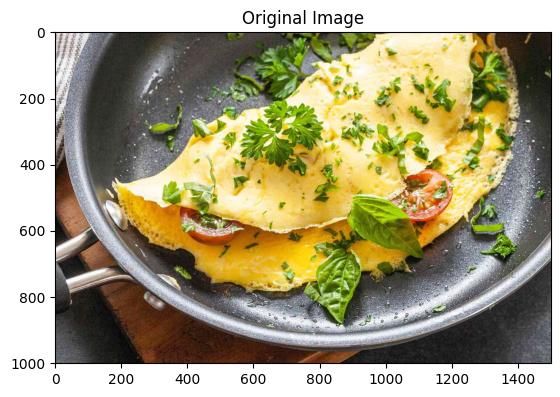

The predicted class is: omelette


In [68]:
image_path = '/content/test/oml.jpg'
predicted_class = predict_class(model, image_path, encoder)
print(f'The predicted class is: {predicted_class}')